# Empirical Illustration of Incompatible Fairness Definitions in Risk Scoring

In [17]:
# Imports

for pkg in ["pandas","numpy","matplotlib","scikit-learn"]:
    try:
        __import__(pkg)
        print(f"{pkg} déjà installé")
    except ImportError:
        print(f"{pkg} non trouvé. Installation en cours...")
        !pip install {pkg}

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pandas déjà installé
numpy déjà installé
matplotlib déjà installé
scikit-learn non trouvé. Installation en cours...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 70.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 100.8 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]


## 1) Illustration of the Incompatibility Using the COMPAS Dataset

### Chargement du jeu de données COMPAS

Cette cellule charge le jeu de données **COMPAS two-year recidivism** mis à disposition par ProPublica.  
Ce jeu de données contient des informations individuelles (caractéristiques démographiques, scores COMPAS, récidive observée) pour des personnes évaluées par le système COMPAS.

Le fichier est hébergé publiquement sur GitHub et peut être chargé directement via son URL.

In [10]:
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df = pd.read_csv(url)

df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


### Définition du cadre expérimental et correspondance avec la notation théorique

Dans *Inherent Trade-Offs in the Fair Determination of Risk Scores* (Kleinberg et al., 2016),  
les auteurs formalisent le problème à l’aide de trois variables fondamentales :

- \( Y \) : variable de résultat binaire représentant l’événement à prédire,
- \( S \) : score de risque attribué à un individu,
- \( G \) : variable de groupe définissant une partition de la population.

Dans le cadre de l’analyse empirique basée sur le jeu de données **COMPAS**, ces variables
correspondent aux colonnes suivantes :

- **\( Y \)** (*Outcome*)  
  → **two_year_recid**  
  Variable binaire indiquant si un individu a récidivé dans les deux ans suivant l’évaluation  
  (\( Y = 1 \) en cas de récidive, \( Y = 0 \) sinon).

- **\( S \)** (*Risk score*)  
  → **decile_score**  
  Score COMPAS discretisé en 10 déciles, où des valeurs plus élevées indiquent un risque
  de récidive plus important.

- **\( G \)** (*Group membership*)  
  → **race**  
  Variable catégorielle représentant l’appartenance raciale.  
  L’analyse se concentre uniquement sur les groupes *African-American* et *Caucasian*.


In [11]:
# Nombre d'observations avant filtrage

print("Nombre total d'observations :", len(df))

# Définition du cadre

# Label Y : récidive à 2 ans
label_col = "two_year_recid"

# Score S : score COMPAS discret (bins naturels)
score_col = "decile_score"

# Groupe G : race (on garde uniquement African-American / Caucasian)
group_col = "race"
groups_of_interest = ["African-American", "Caucasian"]

# Filtrage des groupes
df = df[df[group_col].isin(groups_of_interest)]

# Suppression des valeurs manquantes essentielles
df = df.dropna(subset=[label_col, score_col, group_col])

print("Nombre d'observations après filtrage :", len(df))

Nombre total d'observations : 7214
Nombre d'observations après filtrage : 6150


### Vérification des taux de base et validité de l’hypothèse du théorème

Cette cellule calcule les taux de base de récidive pour chaque groupe, c’est-à-dire : P(Y = 1 | G), condition centrale du théorème d’impossibilité de Kleinberg et al. (2016).

Les taux de base mesurent la probabilité moyenne de récidive observée dans chaque groupe,
indépendamment du score de risque.  
Le théorème stipule que si ces taux diffèrent entre groupes, alors il est impossible de
satisfaire simultanément certaines définitions d’équité (calibration, équilibres pour les classes positives et négatives).


#### Interprétation des résultats

La comparaison explicite des taux de base entre groupes permet de déterminer si
l’hypothèse clé du théorème est satisfaite :

$$ 
P(Y=1 \mid G=\text{Black}) \neq P(Y=1 \mid G=\text{White})
$$  

Si les taux de base sont différents, alors les conditions d'équité ne peuvent pas être. satisfaites simultanément. Cette étape établit donc formellement le cadre dans lequel les conflits entre définitions d’équité peuvent avoir lieu.


In [12]:
# Vérification des taux de base (condition du théorème)

base_rates = (
    df.groupby(group_col)[label_col]
      .mean()
      .rename("Base rate P(Y=1 | G)")
)

counts = df[group_col].value_counts()

print("\nTaux de base par groupe :")
print(base_rates)

# Différence des taux de base

br_black = base_rates["African-American"]
br_white = base_rates["Caucasian"]

print("\nDifférence des taux de base (Black - White) :",
      br_black - br_white)

if br_black != br_white:
    print("\nLes taux de base diffèrent : le théorème de Kleinberg et al. s'applique.")
else:
    print("\nLes taux de base sont égaux : le théorème ne s'applique pas.")



Taux de base par groupe :
race
African-American    0.514340
Caucasian           0.393643
Name: Base rate P(Y=1 | G), dtype: float64

Différence des taux de base (Black - White) : 0.12069679505498576

Les taux de base diffèrent : le théorème de Kleinberg et al. s'applique.


### Calcul de la calibration par bin pour chaque groupe

Cette cellule permet d’évaluer la calibration du score COMPAS au sein de chaque groupe. La calibration est une notion centrale dans l’article de Kleinberg et al. : un score est calibré within groups si, pour un score donné \(S=s\), la probabilité  de récidive est la même pour tous les individus ayant ce score, au sein de chaque groupe \(G\) :

$$
P(Y=1 \mid S=s, G=g) = s
$$


In [13]:
label_col = "two_year_recid"
score_col = "decile_score"
group_col = "race"
groups = ["African-American", "Caucasian"]

# Calcul de la calibration par bin

calibration_table = (
    df.groupby([group_col, score_col])[label_col]
      .agg(
          empirical_rate="mean",
          count="size"
      )
      .reset_index()
)

# Score "théorique" associé au bin (normalisé entre 0 et 1)
calibration_table["score_value"] = calibration_table[score_col] / 10.0

print("\nTable de calibration par groupe et par bin :")
print(calibration_table.head(20))



Table de calibration par groupe et par bin :
                race  decile_score  empirical_rate  count  score_value
0   African-American             1        0.228643    398          0.1
1   African-American             2        0.302799    393          0.2
2   African-American             3        0.419075    346          0.3
3   African-American             4        0.459740    385          0.4
4   African-American             5        0.482192    365          0.5
5   African-American             6        0.559896    384          0.6
6   African-American             7        0.592500    400          0.7
7   African-American             8        0.682451    359          0.8
8   African-American             9        0.707895    380          0.9
9   African-American            10        0.793706    286          1.0
10         Caucasian             1        0.208517    681          0.1
11         Caucasian             2        0.313019    361          0.2
12         Caucasian           

### Visualisation de la calibration par groupe

Dans l’idéal, pour un score \(S=s\) et un groupe \(G=g\), la calibration est définie comme :

$$
P(Y=1 \mid S=s, G=g) = s
$$

Cependant, dans notre jeu de données COMPAS, le score \(S\) est discret, en déciles (1 à 10), et non continu. Le "score théorique" normalisé que nous avons défini (**score_value = decile_score / 10**) ne correspond pas exactement aux probabilités réelles de récidive dans chaque bin. Ainsi, il est impossible de tester strictement $P(Y=1 \mid S=s, G=g) = s$. Nous testons plutôt une version comparative entre groupes : 

$$
P(Y=1 \mid S=s, G=African-American) \approx P(Y=1 \mid S=s, G=Caucasian)
$$

Cela permet d’évaluer si, pour un même bin de score, la probabilité empirique de récidive est similaire entre les groupes.


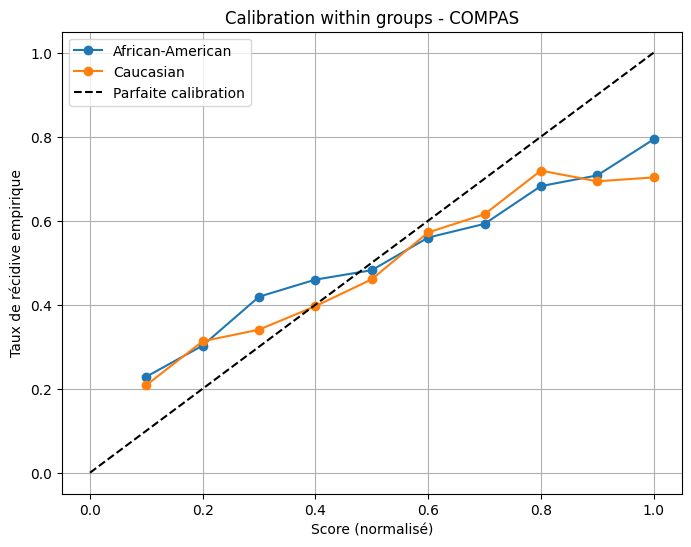

In [ ]:
import matplotlib.pyplot as plt

# Liste des groupes
groups = calibration_table[group_col].unique()

plt.figure(figsize=(8,6))

for g in groups:
    sub = calibration_table[calibration_table[group_col] == g]
    plt.plot(sub["score_value"], sub["empirical_rate"], marker='o', label=g)

# Ligne diagonale pour référence (score_value = emp. rate si parfaitement calibré)
plt.plot([0,1], [0,1], 'k--', label="Parfaite calibration")

plt.xlabel("Score")
plt.ylabel("Taux de récidive empirique")
plt.title("Calibration within groups - COMPAS")
plt.legend()
plt.grid(True)
plt.show()


### Conclusion sur la calibration du score COMPAS

L'analyse empirique des taux de récidive par bin de score montre que, pour les groupes **African-American** et **Caucasian**, le score COMPAS est approximativement calibré within groups :

- Les taux de récidive empirique augmentent de manière monotone avec le score pour chaque groupe.
- Les écarts observés entre les deux groupes sont relativement faibles 




### Vérification des conditions d'équité "balance for the positive class" et "balance for the negative class"

Après avoir évalué la calibration du score COMPAS, nous allons tester si le modèle satisfait les conditions d'équité **balance for the positive class** et **balance for the negative class** :

- **Balance for the positive class** : les scores moyens des individus ayant récidivé (\(Y=1\)) doivent être égaux entre groupes.
$$
\mathbb{E}[S \mid Y=1, G=0] \stackrel{?}{=} \mathbb{E}[S \mid Y=1, G=1]
$$

- **Balance for the negative class** : les scores moyens des individus n’ayant pas récidivé (\(Y=0\)) doivent être égaux entre groupes.
$$
\mathbb{E}[S \mid Y=0, G=0] \stackrel{?}{=} \mathbb{E}[S \mid Y=0, G=1]
$$

Si les taux de base diffèrent et que la calibration est respectée, on ne peut pas simultanément satisfaire ces deux conditions.


In [15]:
# Calcul des scores moyens par groupe pour chaque classe Y

positive_scores = df[df[label_col] == 1].groupby(group_col)[score_col].mean()
negative_scores = df[df[label_col] == 0].groupby(group_col)[score_col].mean()

print("Scores moyens pour la classe positive (Y=1) :")
print(positive_scores)

print("\nScores moyens pour la classe négative (Y=0) :")
print(negative_scores)


Scores moyens pour la classe positive (Y=1) :
race
African-American    6.287217
Caucasian           4.817805
Name: decile_score, dtype: float64

Scores moyens pour la classe négative (Y=0) :
race
African-American    4.396100
Caucasian           3.032258
Name: decile_score, dtype: float64


### Conclusion sur la "balance for positive/negative class"

L'analyse des scores moyens par groupe montre que :

- **Classe positive (Y=1)** : les individus African-American ont un score moyen de **6.29**, tandis que les Caucasian ont un score moyen de **4.82**.  
- **Classe négative (Y=0)** : les individus African-American ont un score moyen de **4.40**, tandis que les Caucasian ont un score moyen de **3.03**.

Ces résultats indiquent que les scores moyens diffèrent entre groupes, ce qui signifie que la **balance for the positive class** et la **balance for the negative class** ne sont pas respectées, illustrant le théorème d'impossibilité.

Il est important de noter que ces calculs sont approximatifs car le score COMPAS est discret en déciles, et non continu. En dépit de cette approximation, les résultats illustrent clairement le trade-off empirique prédit par le théorème d’impossibilité de Kleinberg et al. : lorsque les taux de base diffèrent et que la calibration est respectée, il est impossible de satisfaire les balance entre groupes.

Les différences observées suggèrent que le modèle de scoring COMPAS semble biaisé et injuste envers les African-American, car pour un même résultat $ Y $, ils reçoivent en moyenne des scores plus élevés que les Caucasian.

Cependant, il s’agit également d’une limitation mathématique fondamentale : les taux de base $P(Y=1 \mid G)$ étant distincts, si le modèle est bien calibré within groups, il est mathématiquement impossible de satisfaire simultanément les définitions d’équité basées sur la balance pour la classe positive et la classe négative. C'est ce qu'énonce et formalise le théorème d’impossibilité de Kleinberg et al.



## 2) Illustration using logistic regression with the COMPAS dataset

### Logistic Regression Model to Generate Risk Scores 

We train a logistic regression to predict 2-year recidivism (**two_year_recid**) using the following features:

**Features used**:

- **age** : Age of the individual  
- **priors_count.1** : Number of prior offenses  
- **c_charge_degree** : Charge degree (misdemeanor/felony)  
- **age_cat** : Age category   

The output $S = \hat{P}(Y=1 \mid X)$ will serve as a continuous risk score, suitable for illustrating calibration and fairness trade-offs.


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


# Features to use (excluding sex)
features = ["age", "priors_count.1", "c_charge_degree", "age_cat"]
target = "two_year_recid"

# Prepare the DataFrame for modeling
df_model = df[features + [target, "race"]].copy()

# Encode categorical variables as dummies
categorical_vars = ["c_charge_degree", "age_cat"]
df_model = pd.get_dummies(df_model, columns=categorical_vars, drop_first=True)

# Separate X and y
X = df_model.drop([target, "race"], axis=1)
y = df_model[target]

# Standardize numeric features
numeric_vars = ["age", "priors_count.1"]
scaler = StandardScaler()
X[numeric_vars] = scaler.fit_transform(X[numeric_vars])

# Train logistic regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X, y)

# Predicted probabilities as continuous risk scores
df["logreg_score"] = logreg.predict_proba(X)[:, 1]

print("First 10 predicted risk scores:")
print(df[["logreg_score"]].head(10))


First 10 predicted risk scores:
    logreg_score
1       0.319835
2       0.657725
3       0.557572
6       0.749696
8       0.239989
9       0.582179
10      0.400570
11      0.598409
12      0.258778
13      0.248624


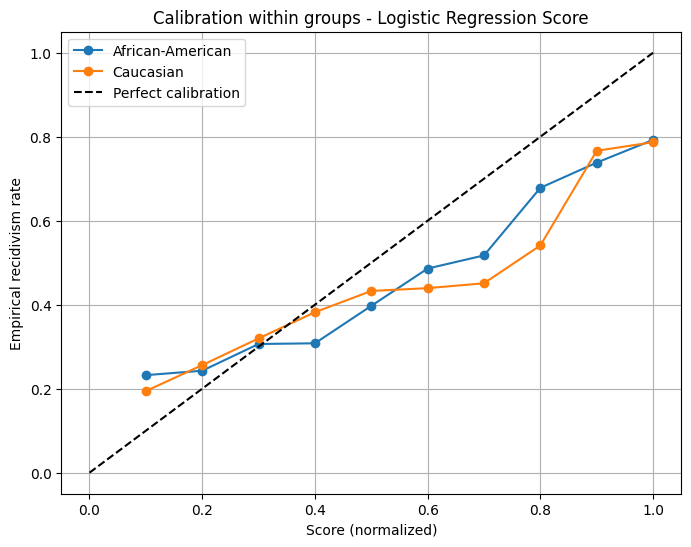

In [ ]:
# Découpage du score en bins pour visualiser la calibration
df["score_bin"] = pd.qcut(df["logreg_score"], 10, labels=False, duplicates='drop') + 1

# Table de calibration
calibration_table = (
    df.groupby(["race", "score_bin"])["two_year_recid"]
      .agg(empirical_rate="mean", count="size")
      .reset_index()
)

# Score "théorique" associé au bin (normalisé entre 0 et 1)
calibration_table["score_value"] = calibration_table["score_bin"] / 10.0

# Visualisation
plt.figure(figsize=(8,6))
for g in calibration_table["race"].unique():
    sub = calibration_table[calibration_table["race"] == g]
    plt.plot(sub["score_value"], sub["empirical_rate"], marker='o', label=g)

# Diagonale pour référence
plt.plot([0,1], [0,1], 'k--', label="Perfect calibration")
plt.xlabel("Score")
plt.ylabel("Empirical recidivism rate")
plt.title("Calibration within groups - Logistic Regression Score")
plt.legend()
plt.grid(True)
plt.show()


In [21]:
# Moyennes conditionnelles par groupe pour Y=1 et Y=0
positive_scores = df[df["two_year_recid"] == 1].groupby("race")["logreg_score"].mean()
negative_scores = df[df["two_year_recid"] == 0].groupby("race")["logreg_score"].mean()

print("Average scores for the positive class (Y=1):")
print(positive_scores)

print("\nAverage scores for the negative class (Y=0):")
print(negative_scores)


Average scores for the positive class (Y=1):
race
African-American    0.576824
Caucasian           0.470780
Name: logreg_score, dtype: float64

Average scores for the negative class (Y=0):
race
African-American    0.441078
Caucasian           0.352244
Name: logreg_score, dtype: float64


A nouveau les conditions d'équité correspondant aux **balance for positive class** et **balance for negative class**, ne sont pas satisfaites. Nous allons essayer de satisfaire ces conditions de façon artificielle par un post-processing afin d'illustrer le théorème d'impossibilité.

### Linear Transformations Applied to Enforce Balance

To ensure **balance for the positive and negative classes**, we applied simple linear shifts to the predicted risk scores by group and class.  

#### Compute target means
For each class \(Y=1\) and \(Y=0\), we computed the target mean as the average of the two groups:

$$
\text{target\_mean\_pos} = \frac{\text{mean(African-American, Y=1)} + \text{mean(Caucasian, Y=1)}}{2}
$$

$$
\text{target\_mean\_neg} = \frac{\text{mean(African-American, Y=0)} + \text{mean(Caucasian, Y=0)}}{2}
$$

#### Apply linear shifts
For each individual, we applied a shift depending on their group and class:

$$
S' = S + (\text{target\_mean} - \text{current\_group\_mean})
$$

- $S$ : original predicted score  
- $S'$ : adjusted score  
- $\text{target\_mean}$ : target mean for the class (positive or negative)  
- $\text{current\_group\_mean}$ : original mean for the individual’s group and class  

#### Effect
- The mean score per group and class is now equal to the target mean 
- The relative ranking of scores within each group and class is preserved 
- This ensures perfect balance for the positive and negative classes




In [ ]:
# Vérification des conditions d'équité : balance for positive class et balance for negative class

df_adjusted = df.copy()

# Moyennes actuelles
mean_pos = df_adjusted[df_adjusted["two_year_recid"] == 1].groupby("race")["logreg_score"].mean()
mean_neg = df_adjusted[df_adjusted["two_year_recid"] == 0].groupby("race")["logreg_score"].mean()

# Moyennes cibles
target_mean_pos = mean_pos.mean()
target_mean_neg = mean_neg.mean()

# Ajustement pour Y=1
for race in df_adjusted["race"].unique():
    mask = (df_adjusted["two_year_recid"] == 1) & (df_adjusted["race"] == race)
    df_adjusted.loc[mask, "logreg_score_balanced"] = (
        df_adjusted.loc[mask, "logreg_score"] + (target_mean_pos - mean_pos[race])
    )

# Ajustement pour Y=0
for race in df_adjusted["race"].unique():
    mask = (df_adjusted["two_year_recid"] == 0) & (df_adjusted["race"] == race)
    df_adjusted.loc[mask, "logreg_score_balanced"] = (
        df_adjusted.loc[mask, "logreg_score"] + (target_mean_neg - mean_neg[race])
    )

# Vérification
balanced_pos = df_adjusted[df_adjusted["two_year_recid"] == 1].groupby("race")["logreg_score_balanced"].mean()
balanced_neg = df_adjusted[df_adjusted["two_year_recid"] == 0].groupby("race")["logreg_score_balanced"].mean()

print("Balanced scores for positive class (Y=1):")
print(balanced_pos)

print("\nBalanced scores for negative class (Y=0):")
print(balanced_neg)


Balanced scores for positive class (Y=1):
race
African-American    0.523802
Caucasian           0.523802
Name: logreg_score_balanced, dtype: float64

Balanced scores for negative class (Y=0):
race
African-American    0.396661
Caucasian           0.396661
Name: logreg_score_balanced, dtype: float64


### Conclusion sur le post-processing et le compromis entre les différentes définitions d'équité 

Le post-processing appliqué pour garantir la balance for positive et negative class permet de satisfaire deux définitions d’équité sur trois.

Cependant, cette transformation a un coût important :  

- La calibration du modèle est dégradée, en particulier pour les scores autour de 0.8, comme le montre le graphique ci-dessous.  
- Le pouvoir prédictif global du modèle peut également être affecté, car les scores ont été artificiellement modifiés pour équilibrer les groupes

Cette situation illustre directement le **théorème d’impossibilité de Kleinberg et al. (2016)** :  
Lorsque les taux de base $P(Y=1 \mid G)$ diffèrent entre groupes, il est mathématiquement impossible de construire un score qui soit à la fois calibré et qui respecte toutes les définitions d’équité simultanément.

En résumé, le post-processing est un outil permettant d'atteindre certaines définitions d’équité, mais il ne permet pas de garantir toutes les conditions d'équité car il s'agit d'une impossibilité mathématiques.


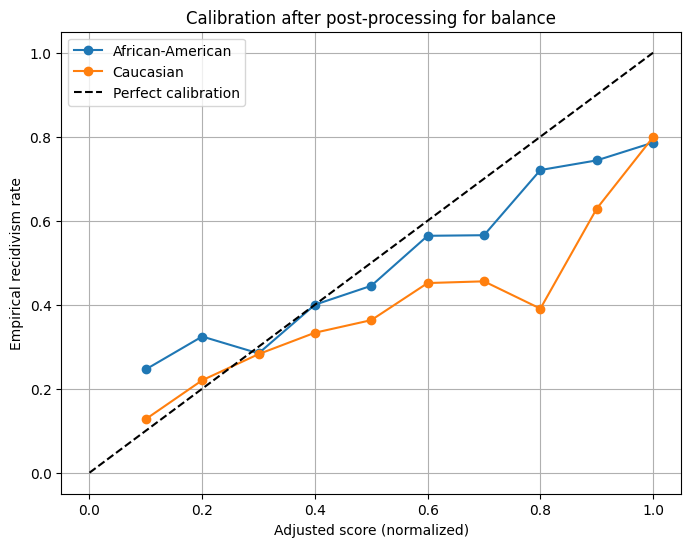

In [ ]:
# Découpage du score ajusté en bins pour visualiser la calibration
df_adjusted["score_bin"] = pd.qcut(df_adjusted["logreg_score_balanced"], 10, labels=False, duplicates='drop') + 1

# Table de calibration
calibration_table = (
    df_adjusted.groupby(["race", "score_bin"])["two_year_recid"]
        .agg(empirical_rate="mean", count="size")
        .reset_index()
)

# Score "théorique" associé au bin (normalisé entre 0 et 1)
calibration_table["score_value"] = calibration_table["score_bin"] / 10.0

# Visualisation
plt.figure(figsize=(8,6))
for g in calibration_table["race"].unique():
    sub = calibration_table[calibration_table["race"] == g]
    plt.plot(sub["score_value"], sub["empirical_rate"], marker='o', label=g)

# Diagonale pour référence
plt.plot([0,1], [0,1], 'k--', label="Perfect calibration")
plt.xlabel("Adjusted score")
plt.ylabel("Empirical recidivism rate")
plt.title("Calibration after post-processing")
plt.legend()
plt.grid(True)
plt.show()
